In [2]:
#!/opt/miniconda3/envs/thesis/bin python

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'


import os
import shutil
import tempfile
from contextlib import contextmanager

import sys
from subprocess import Popen, PIPE, CalledProcessError, run
# from io import StringIO
import time
from gvar import gvar
from UWerr import UWerr
from ruamel.yaml import YAML

from IPython.display import HTML, display
from ipywidgets.widgets import Output
import io

In [3]:
class Observable(object):
    def __init__(self,label,func,scale = 'linear'):
        self.label = label
        self.func = func
        self.scale = scale

    def __call__(self, data):
        average = self.func(data)
        return gvar(average, self.jackknife(data, average))

    def jackknife(self, data, average=None, tau=0.5):
        cumsum = 0
        if average is None: 
            average = self.func(data)
        for i in data.index:
            cumsum += ( self.func(data.drop(i)) - average )**2
#         return np.sqrt(2 * tau * cumsum * data.size)
        return np.sqrt(2 * (data.size - 1) / data.size * tau * cumsum)

global_observables = dict(
    S               =   Observable(r"S", 
                                   lambda data: np.mean(data['S']/(data['beta']*L**2)) ),
    internal_energy =   Observable(r"E", 
                                   lambda data: np.mean(data['S']/(0.5*data['beta']*L**2)) ),
    chi_m           =   Observable(r"\chi_m", 
                                   lambda data: np.mean(data['chi_m'])/L**2, scale='log'),
    delta_m         =   Observable(r"\delta_m",
                            lambda data,beta:
                                2 * 10**5 * beta**4 * np.exp(-4*np.pi*beta) * np.mean(data['chi_m'])/(L**2),
                            scale = 'log'),
    Q               =   Observable(r"\langle Q \rangle", 
                                   lambda data: np.mean(data['Q'])),
    chi_t           =   Observable(r"\langle Q^2 \rangle", 
                                   lambda data: np.mean(data['Q']**2), scale='log')
    

)

# @contextmanager
# def named_pipes(n=1):
#     dirname = tempfile.mkdtemp()
#     try:
#         paths = [os.path.join(dirname, 'named_pipe' + str(i)) for i in range(n)]
#         for path in paths:
#             os.mkfifo(path)
#         yield paths
#     finally:
#         shutil.rmtree(dirname)

def print_stats():
    print(f"{measurements} measurements every {record_rate} sweeps, {thermalization} sweep thermalization.")
    
def get_data(output_file="outputs/data.csv"):
    data = pd.read_csv(output_file)
    data = data.round({'Q':0}).astype({'Q':'int32'})
    return data

In [71]:
bietenholz_params = pd.DataFrame(data = {
    'L' : [24, 36, 54, 80, 120, 180, 270, 404],
    'beta' : [1.263, 1.370, 1.458, 1.535, 1.607, 1.677, 1.743, 1.807],
    't0' : [0.1, 0.225, 0.506, 1.111, 2.5, 5.625, 12.656, 28.336],
    'xi2': [3.96, 6.01, 8.93, 13.24, 19.77, 30.01, 44.97, 67.66]
})
colors = ['black','red','blue','yellow','orange','cyan','green','purple']

In [5]:
cores = 1

taus = np.linspace(0,10,11)
#taus = [0.]
#taus = np.array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 20.])

measurements = 1000
thermalization = 1000
record_rate = 50

# Generate 

In [231]:
yaml = YAML()
yaml.indent(sequence=4, offset=2)

def o_filename(i): return f"outputs/gf/params_{i}.csv"
def i_filename(i): return f"inputs/gf/params_{i}.yml"
o_filenames = []

processes = []
for i, p in bietenholz_params.iterrows():
    scaled_taus = [float(tau*p.t0) for tau in taus]
    yaml_data =  {
            'beta': float(p.beta),
            'L':    float(p.L),
            'measurements': measurements,
            'thermalization': thermalization,
            'record_rate': record_rate,
            'taus': scaled_taus
    }
    o_filenames.append(o_filename(i))
    with open(i_filename(i), 'w') as yaml_file:
        yaml.dump(yaml_data, yaml_file)

Run

In [41]:
for i, (L, beta, t0) in enumerate(zip(Ls, betas, t0s)):
    cmd = ["mpiexec",
            "-n", str(cores),
            "cpp_code/bin/sweep",
            "-i", i_filename(i),
            "-o", o_filename(i)]
    print(' '.join(cmd))
    o_filenames.append(o_filename(i))
#     with open(path, 'wb', 0) as pipe:
#         print(path)
    processes.append( Popen(cmd, stdout=PIPE, stderr=PIPE, bufsize=1, universal_newlines=True) )

mpiexec -n 1 cpp_code/bin/sweep -i inputs/gf/params_0.yml -o outputs/gf/params_0.csv
mpiexec -n 1 cpp_code/bin/sweep -i inputs/gf/params_1.yml -o outputs/gf/params_1.csv
mpiexec -n 1 cpp_code/bin/sweep -i inputs/gf/params_2.yml -o outputs/gf/params_2.csv
mpiexec -n 1 cpp_code/bin/sweep -i inputs/gf/params_3.yml -o outputs/gf/params_3.csv


In [42]:
# Montior progress
progresses = [Output(layout={'border': '1px solid black'}) for _ in processes]
[display(progress) for progress in progresses]
delay = 0.1
started = [False for _ in processes]
finished = [False for _ in processes]
last_prints = [time.time() for _ in processes]

        
while not all(finished):
    for i,p in enumerate(processes):
        line = p.stdout.readline()
        if "Working" in line:
            if (time.time() - last_prints[i]) > delay:
                progresses[i].clear_output()
                if "Working" in line:
                    if not started[i]:
                        started[i] = True
                    with progresses[i]:
                        print(f" {i}> " + line)
                last_prints[i] = time.time()
        else:
            progresses[i].clear_output()
            if started[i]:
                finished[i] = True
            with progresses[i]:
                print(f" {i}| " + line)
            

Output(layout=Layout(border='1px solid black'))

Output(layout=Layout(border='1px solid black'))

Output(layout=Layout(border='1px solid black'))

Output(layout=Layout(border='1px solid black'))

In [43]:
# # Combine the files
with open(output_file, 'w') as sumfile:
    needs_header = True
    for ofilename in o_filenames:
        with open(ofilename,'r') as ofile:
            if needs_header:
                sumfile.write(next(ofile))
                needs_header = False
            else:
                next(ofile)
            sumfile.write(ofile.read())
        os.remove(ofilename)

        
print_stats()

FileNotFoundError: [Errno 2] No such file or directory: 'outputs/gf/params_0.csv'

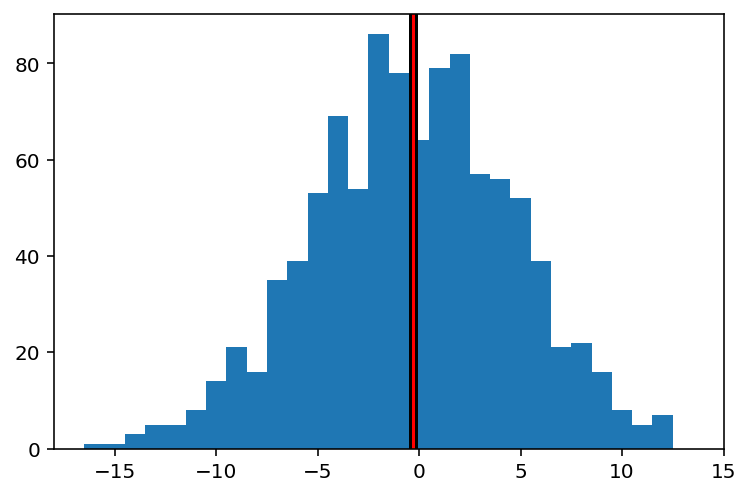

In [65]:
L = 270

def bins(d): return np.arange( np.amin(d)-0.5,np.amax(d)+0.5 )
Q_data = data[(data.tau==0.) & (data.L==L)]
Q_vals = Q_data[['Q']].values[:,0]
plt.hist(Q_vals, bins=bins(Q_vals))
gv = global_observables['Q'](Q_data)
plt.axvline(gv.mean,c='r')
plt.axvline(gv.sdev+gv.mean,c='k')
plt.axvline(-gv.sdev+gv.mean,c='k')


NameError: name 'Ls' is not defined

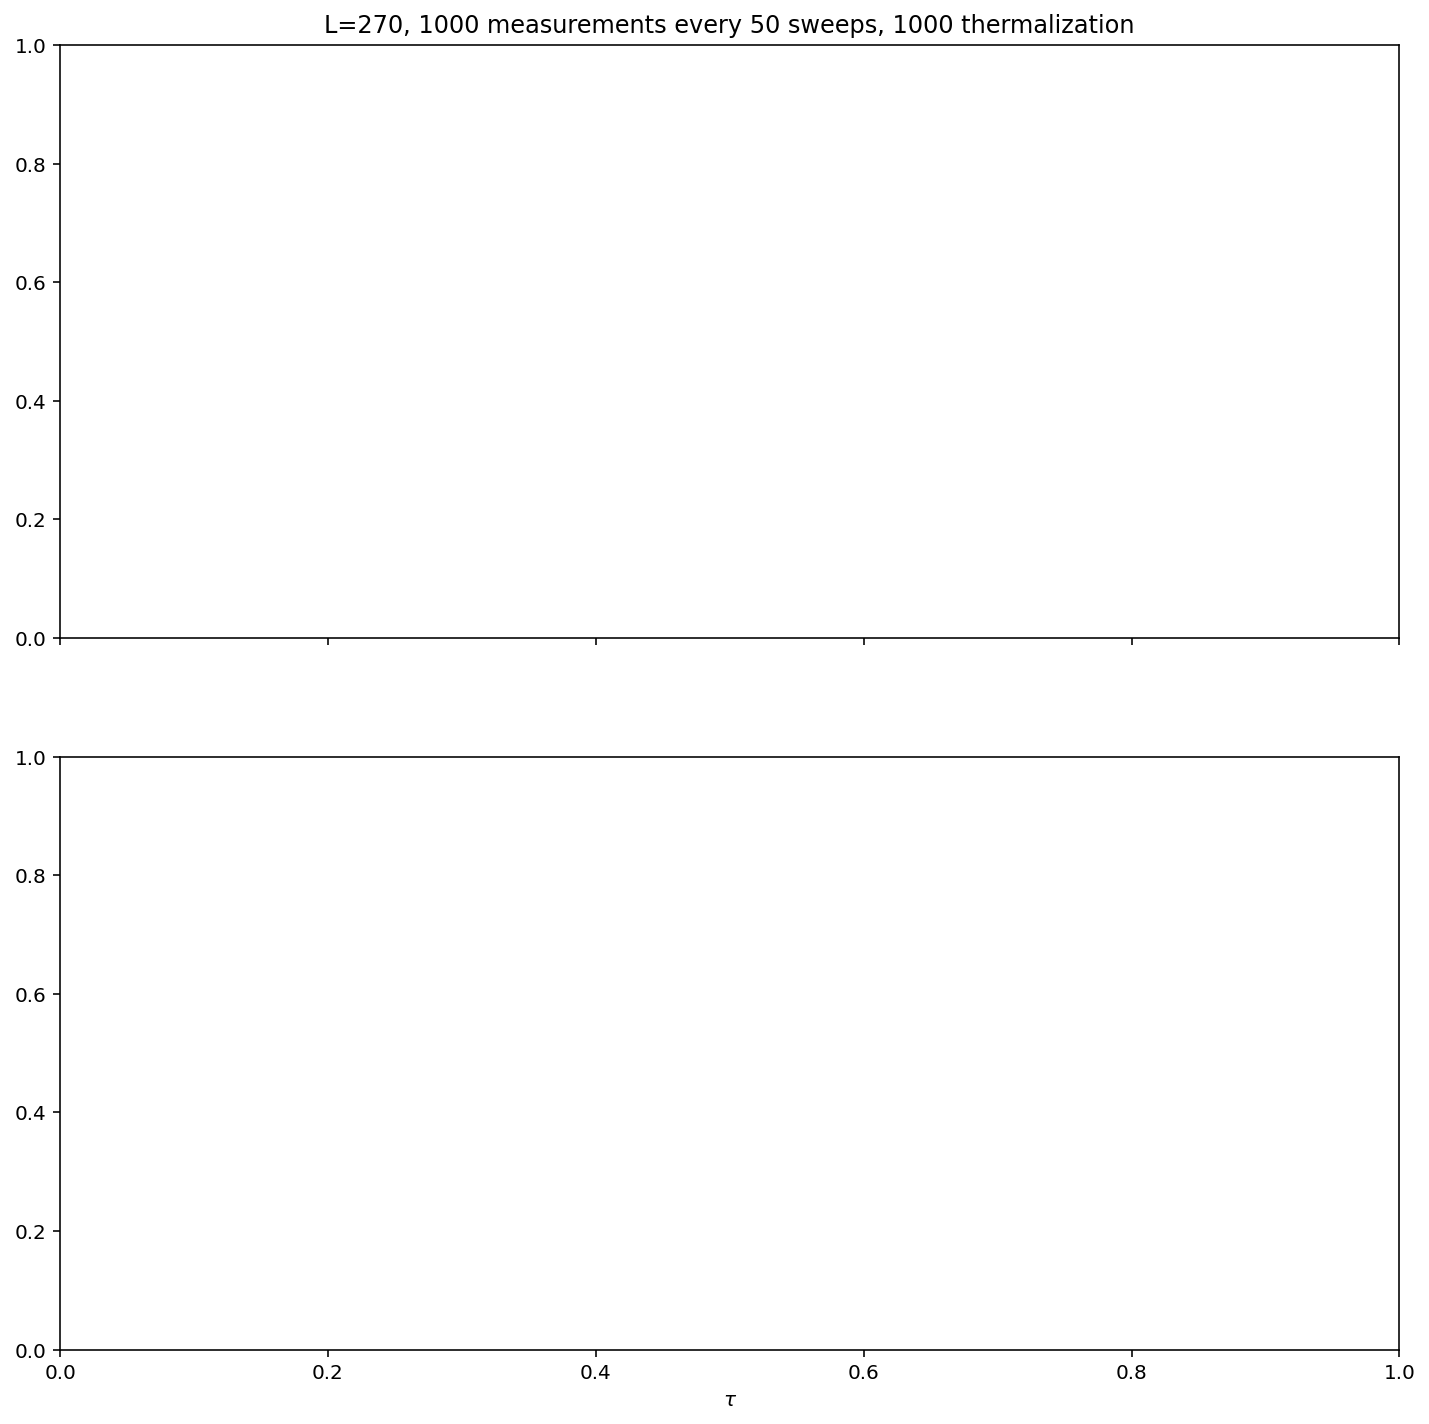

In [69]:
observ_names = ['Q','chi_t']
observ_objs = [global_observables[o] for o in observ_names]

fig,axes = plt.subplots(len(observ_names),1,figsize=(12,6*len(observ_names)), sharex=True, squeeze=False)
axes = [ax for row in axes for ax in row] # flatten axes

axes[0].set_title(f"L={L}, {measurements} measurements every {record_rate} sweeps, {thermalization} thermalization")
axes[-1].set_xlabel(r"$\tau$")


for ax, O in zip(axes, observ_objs):
    for i,p in bietenholz_params.iterrows():
        if L==120: break
        d = []
        for tau in taus:
            trial = data[(round(data['tau'],10) == round(tau*t0,10)) & (data['L'] == L)]
            if trial.size == 0:
                print(tau,L)
                raise Exception("trial returned zero data points")
            d.append(O(trial))

        ax.errorbar(taus, [x.mean for x in d], yerr=[x.sdev for x in d], fmt='.', c=c, label=f"$L={L}$", capsize=3.)
        ax.legend()

    ax.set_xlabel(r'$\tau / \tau_0$')
    ax.set_ylabel('$'+O.label+'$')
    ax.set_yscale(O.scale)
    ax.tick_params(axis='y', which='both', left=True, right=True)
    #ax.set_xlim((0.4, 2.6))
    
axes[0].axhline(0)
axes[1].set_ylim((1,100))

plt.show()

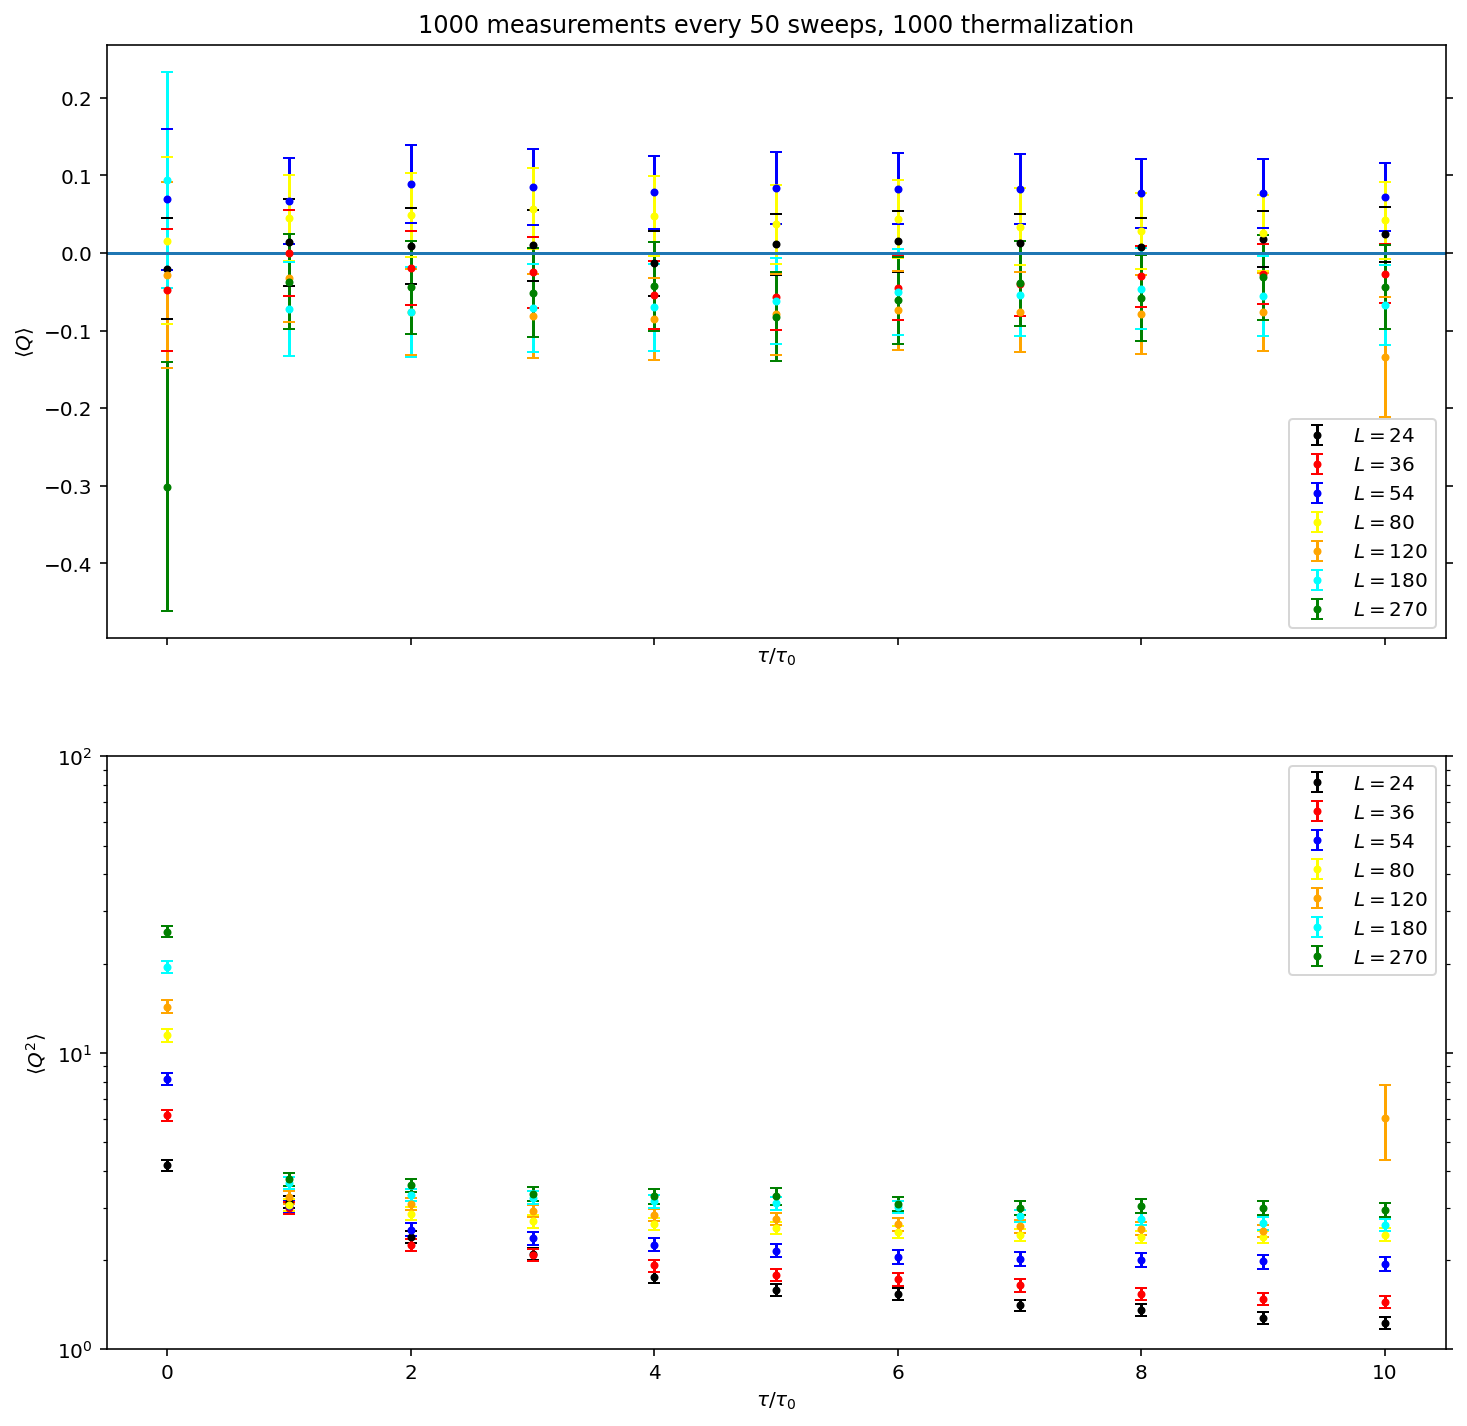

In [72]:
# Reproduce Bietenholz

output_file = "outputs/data.csv"
data = pd.read_csv(output_file)

observ_names = ['Q','chi_t']
observ_objs = [global_observables[o] for o in observ_names]

fig,axes = plt.subplots(len(observ_names),1,figsize=(12,6*len(observ_names)), sharex=True, squeeze=False)
axes = [ax for row in axes for ax in row] # flatten axes

axes[0].set_title(f"{measurements} measurements every {record_rate} sweeps, {thermalization} thermalization")
axes[-1].set_xlabel(r"$\tau$")


for ax, O in zip(axes, observ_objs):
    for i,p in bietenholz_params.iterrows():
        d = []
    
        if data[data['L'] == p.L].size == 0:
            continue
            
        for tau in taus:
            trial = data[(round(data['tau'],10) == round(tau*p.t0,10)) & (data['L'] == p.L)]
            d.append(O(trial))

        ax.errorbar(taus, [x.mean for x in d], yerr=[x.sdev for x in d], fmt='.', c=colors[i], label=f"$L={int(p.L)}$", capsize=3.)
        ax.legend()

    ax.set_xlabel(r'$\tau / \tau_0$')
    ax.set_ylabel('$'+O.label+'$')
    ax.set_yscale(O.scale)
    ax.tick_params(axis='y', which='both', left=True, right=True)
    #ax.set_xlim((0.4, 2.6))
    
axes[0].axhline(0)
axes[1].set_ylim((1,100))

plt.show()

In [19]:
data[data.Q>0]

,tau,beta,L,S,Q
0,0.000,1.263,24,663.754,2.341240e-16
1,0.100,1.263,24,663.754,1.000000e+00
2,0.200,1.263,24,663.754,1.000000e+00
3,0.300,1.263,24,663.754,1.811150e-16
4,0.400,1.263,24,663.754,7.167290e-16
...,...,...,...,...,...
76994,63.280,1.743,270,78508.900,1.000000e+00
76995,75.936,1.743,270,78508.900,1.000000e+00
76996,88.592,1.743,270,78508.900,1.000000e+00
76997,101.248,1.743,270,78508.900,1.000000e+00


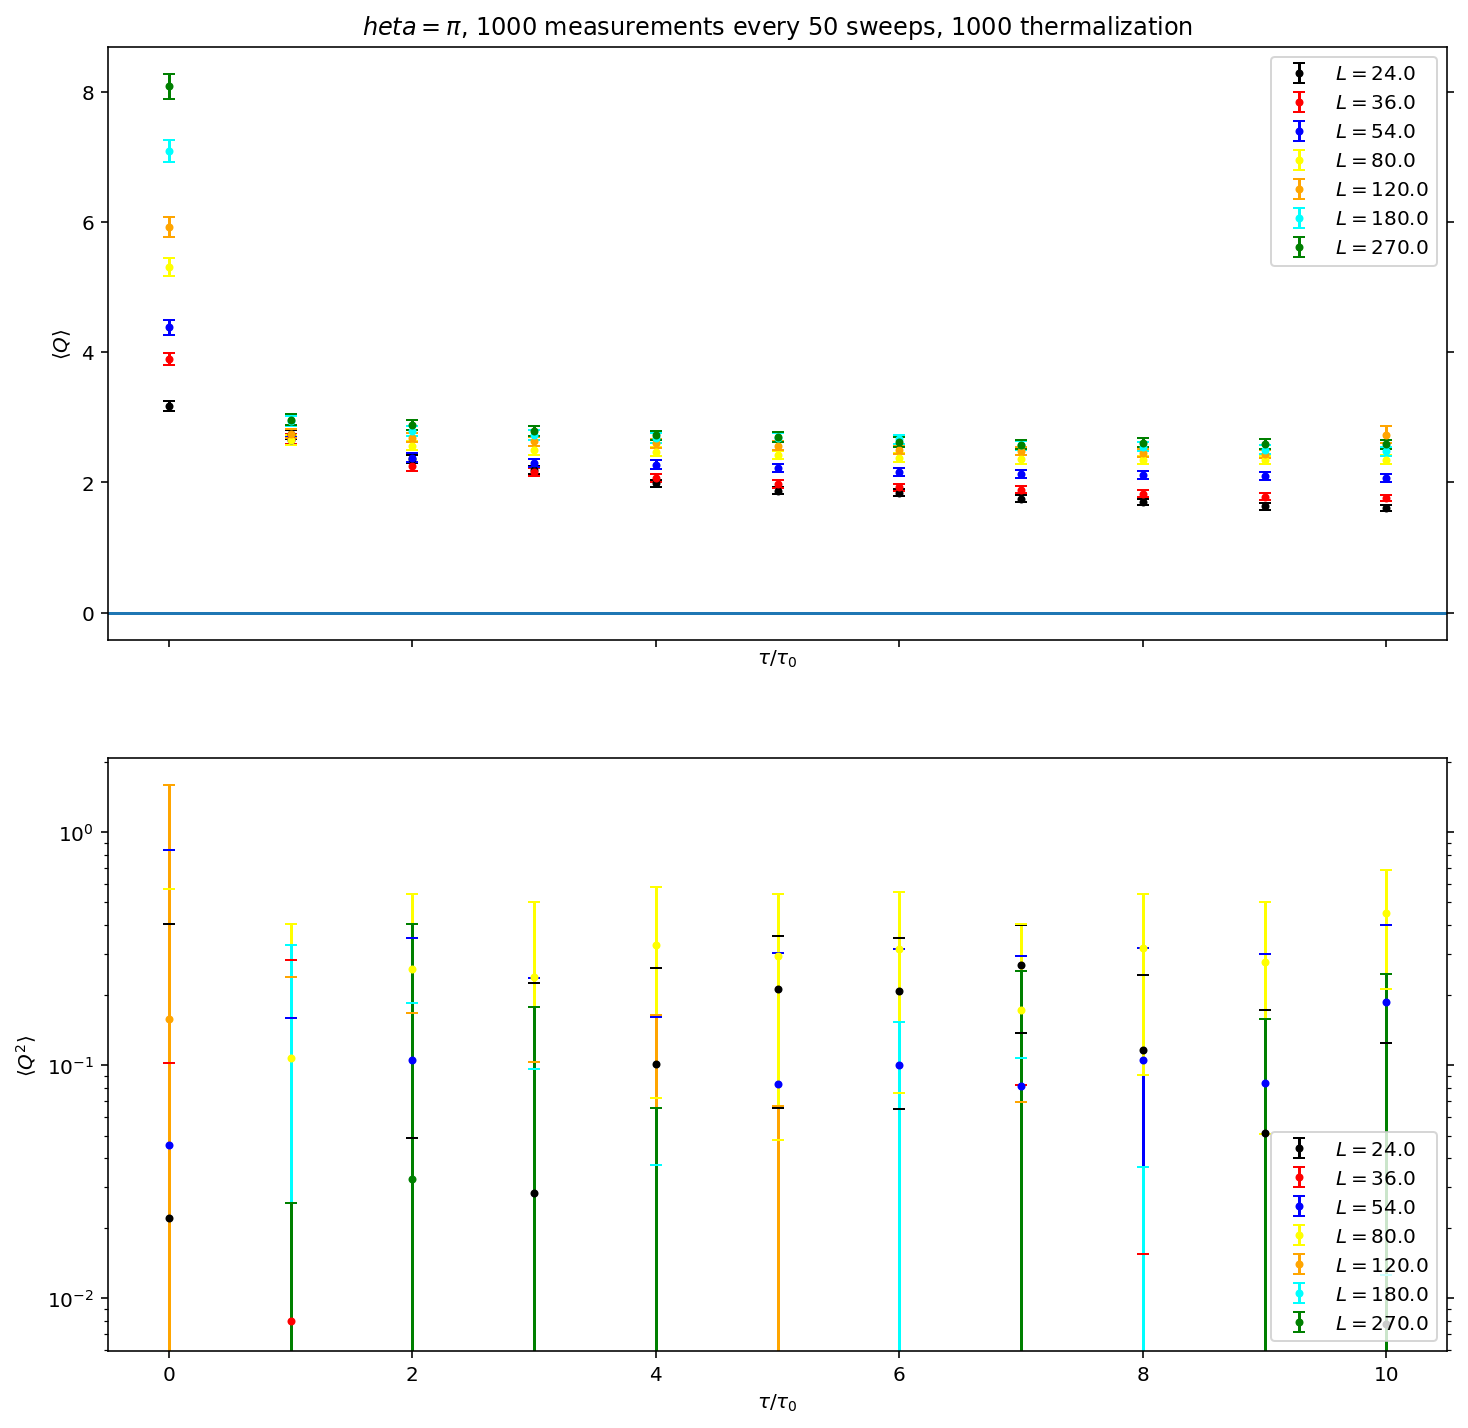

In [26]:
# Reproduce Bietenholz, theta = pi

output_file = "outputs/data.csv"
data = pd.read_csv(output_file)

observ_names = ['Q','chi_t']
observ_objs = [global_observables[o] for o in observ_names]

fig,axes = plt.subplots(len(observ_names),1,figsize=(12,6*len(observ_names)), sharex=True, squeeze=False)
axes = [ax for row in axes for ax in row] # flatten axes

axes[0].set_title(f"$\\theta=\pi$, {measurements} measurements every {record_rate} sweeps, {thermalization} thermalization")
axes[-1].set_xlabel(r"$\tau$")


for ax, O in zip(axes, observ_objs):
    for i,p in bietenholz_params.iterrows():
        #if p.L==120: 
        d = []
        
        if data[data['L'] == p.L].size == 0:
              continue
        
        for tau in taus:
            trial = data[(round(data['tau'],10) == round(tau*p.t0,10)) & (data['L'] == p.L)]
                
            # this line is different
            d.append( O(trial[trial.Q>0]) - O(trial[trial.Q<0]) )

        ax.errorbar(taus, [x.mean for x in d], yerr=[x.sdev for x in d], fmt='.', c=colors[i], label=f"$L={p.L}$", capsize=3.)
        ax.legend()
        
    ax.set_xlabel(r'$\tau / \tau_0$')
    ax.set_ylabel('$'+O.label+'$')
    ax.set_yscale(O.scale)
    ax.tick_params(axis='y', which='both', left=True, right=True)
    #ax.set_xlim((0.4, 2.6))
    
axes[0].axhline(0)
#axes[1].set_ylim((1,100))

plt.show()

1000 measurements every 1 sweeps, 1000 sweep thermalization.


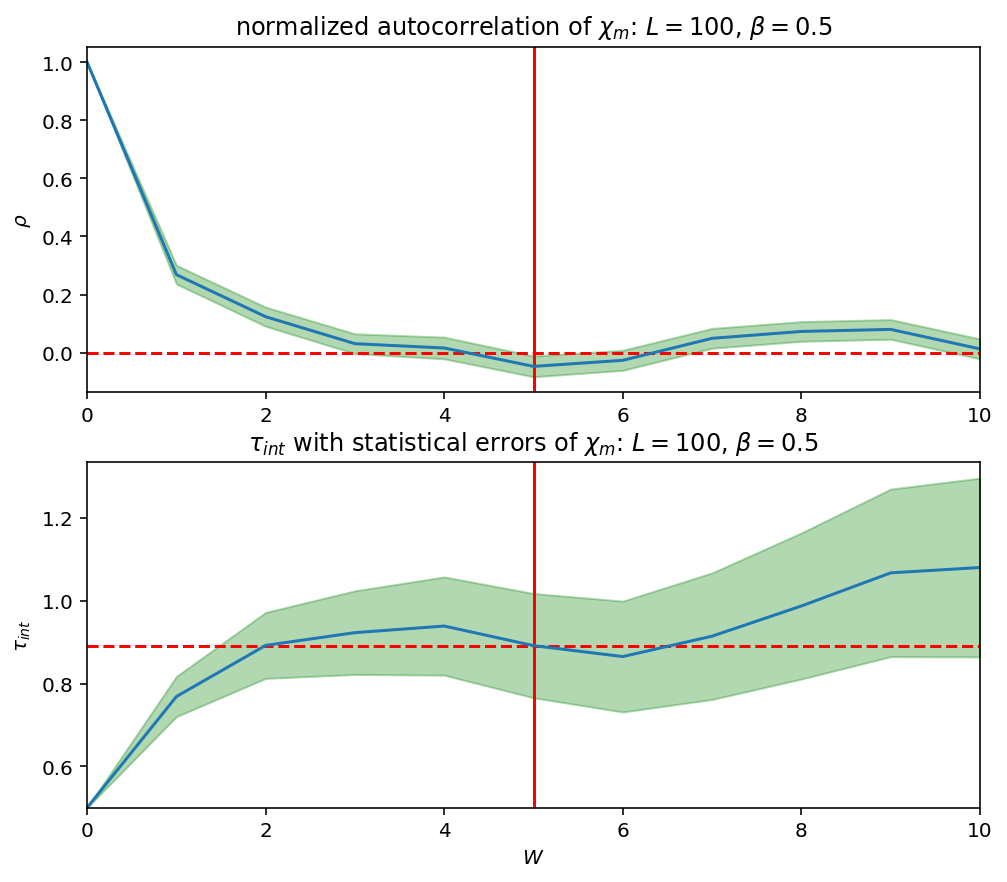

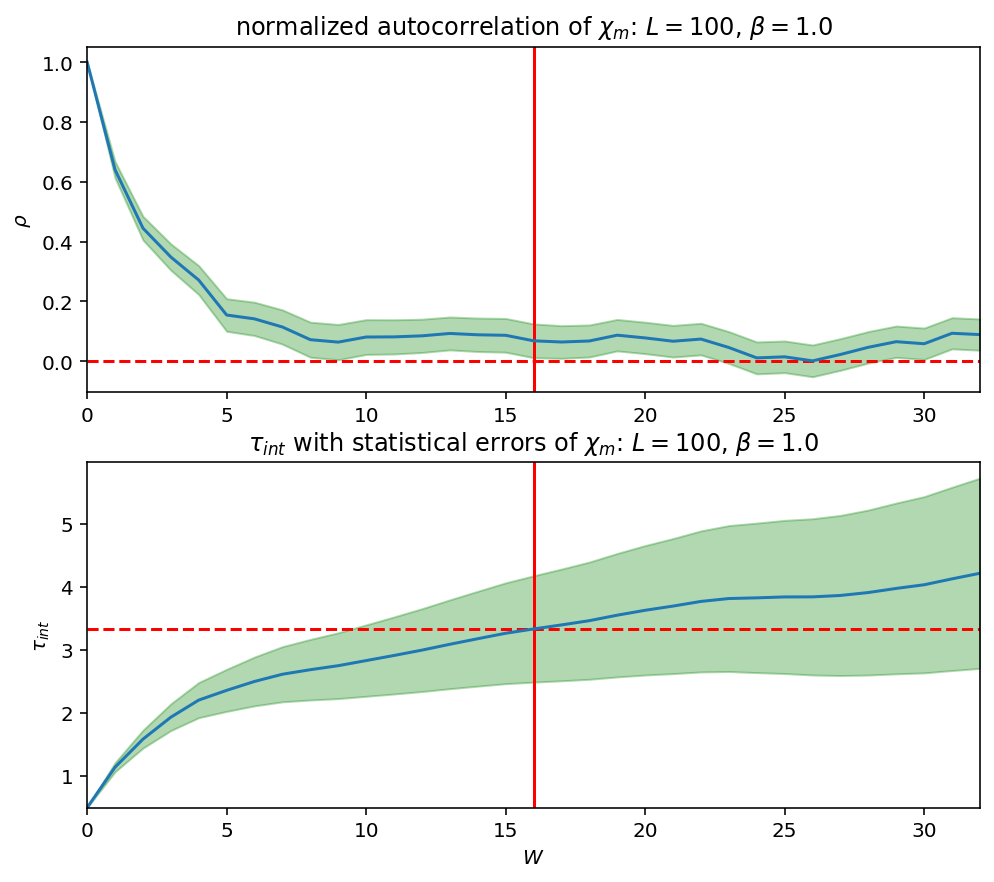

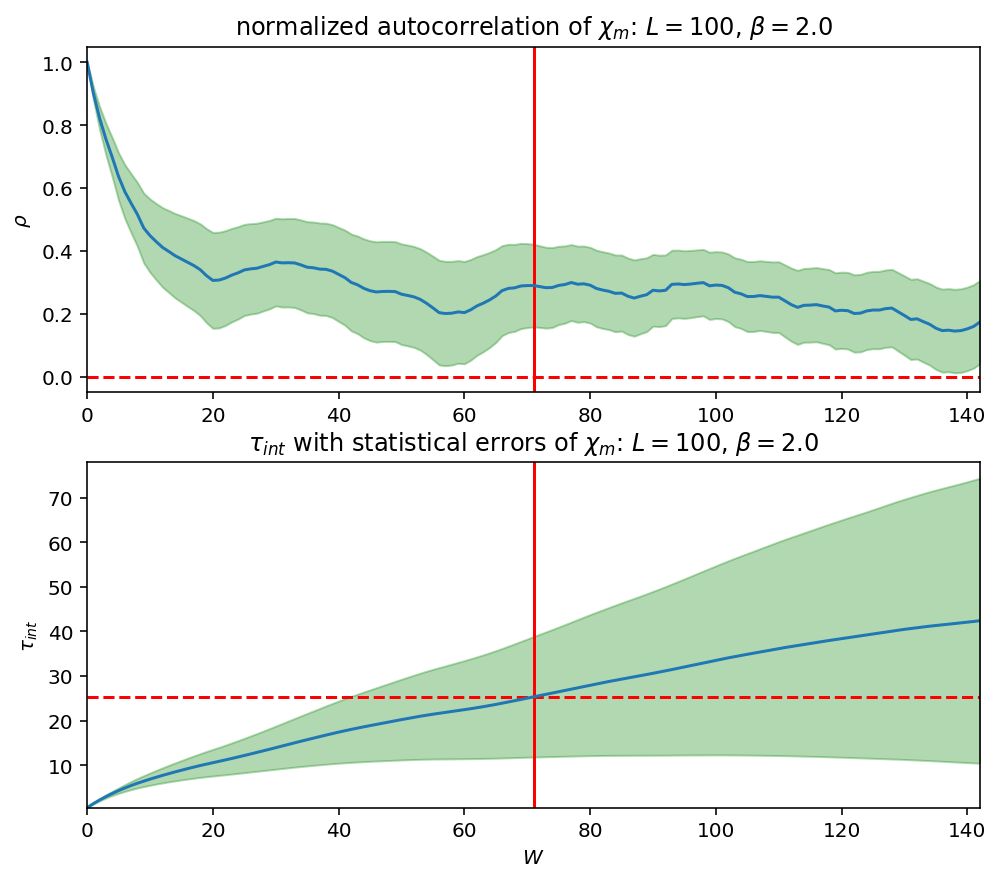

In [307]:
def plot_autocorrelation(beta):
    data = pd.read_csv(output_file)
    name = f"$\\chi_m$: $L={L}$, $\\beta={beta}$"
    series = data[(data['tau'] == 0.) & (data['beta'] == beta)]['chi_m'].to_numpy()
    UWerr(series, name=name, plot=True)

print_stats()
plot_autocorrelation(0.5)
plot_autocorrelation(1.0)
plot_autocorrelation(2.0)


# $\theta \neq 0$

In [106]:
O.label

'\\langle Q^2 \\rangle'

0
1
6


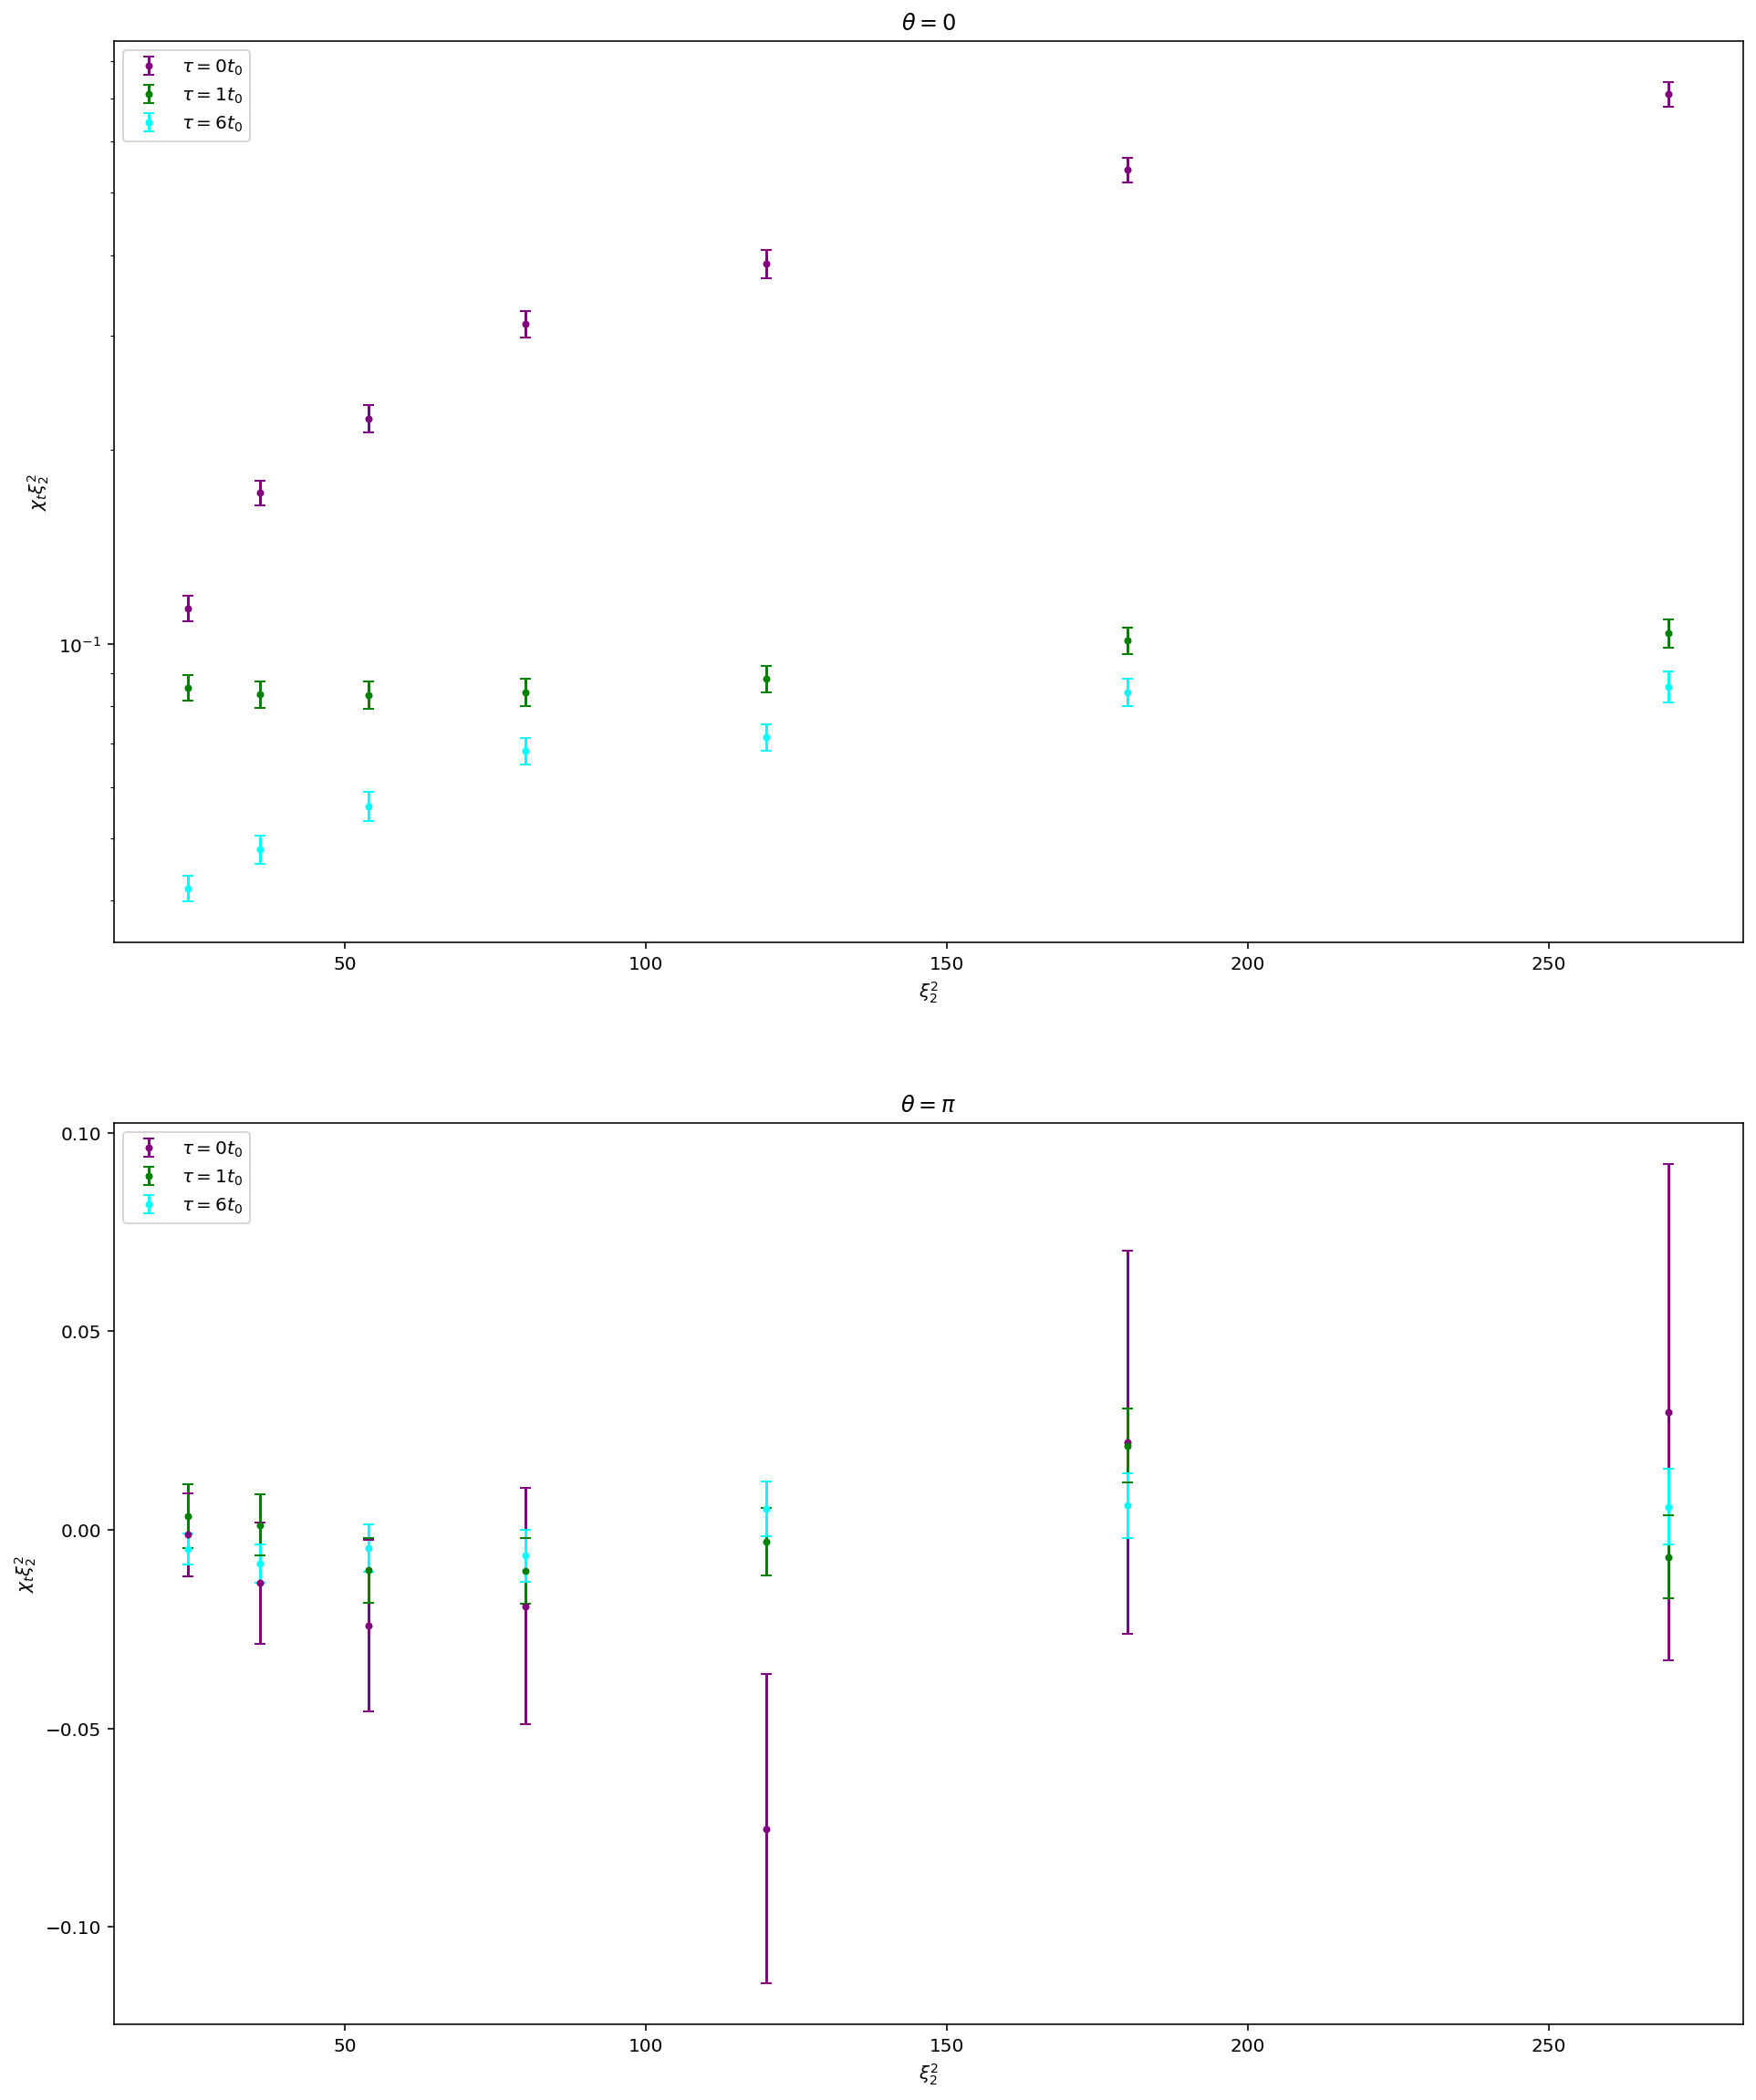

In [109]:
data = get_data()

fig,axes = plt.subplots(2,1,figsize=(16,20))

O = global_observables['chi_t']

plot_taus = [0,1,6]
#plot_taus = [0,1,2,4,6,8,10]
plot_colors = ['purple', 'green', 'cyan', 'orange', 'blue', 'red', 'black']

for i,tau in enumerate(plot_taus):
    print(tau)
    dtriv = []
    dtopo = []

    Ls = []
    for j,p in bietenholz_params.iterrows():
        trial = data[(round(data['tau'],10) == round(tau*p.t0,10)) & (data['L'] == p.L)]
        if trial.size == 0: continue
            
        Ls.append(p.L)
        dtriv.append(O(trial) / p.L**2 * p.xi2**2)
        
        dtopo.append( (O(trial[trial.Q%2==0]) - O(trial[trial.Q%2==1])) / p.L**2 * p.xi2**2)

    axes[0].errorbar(Ls, [x.mean for x in dtriv], yerr=[x.sdev for x in dtriv], fmt='.', c=plot_colors[i], label=f"$\\tau={tau}t_0$", capsize=3.)
    axes[1].errorbar(Ls, [x.mean for x in dtopo], yerr=[x.sdev for x in dtopo], fmt='.', c=plot_colors[i], label=f"$\\tau={tau}t_0$", capsize=3.)


axes[0].set_title(r"$\theta=0$")
axes[1].set_title(r"$\theta=\pi$")
axes[0].set_yscale(O.scale)
for ax in axes:
    ax.legend()
    ax.set_ylabel(r"$\chi_t \xi_2^2$");
    ax.set_xlabel(r"$\xi_2^2$")

plt.show()

0
1
6


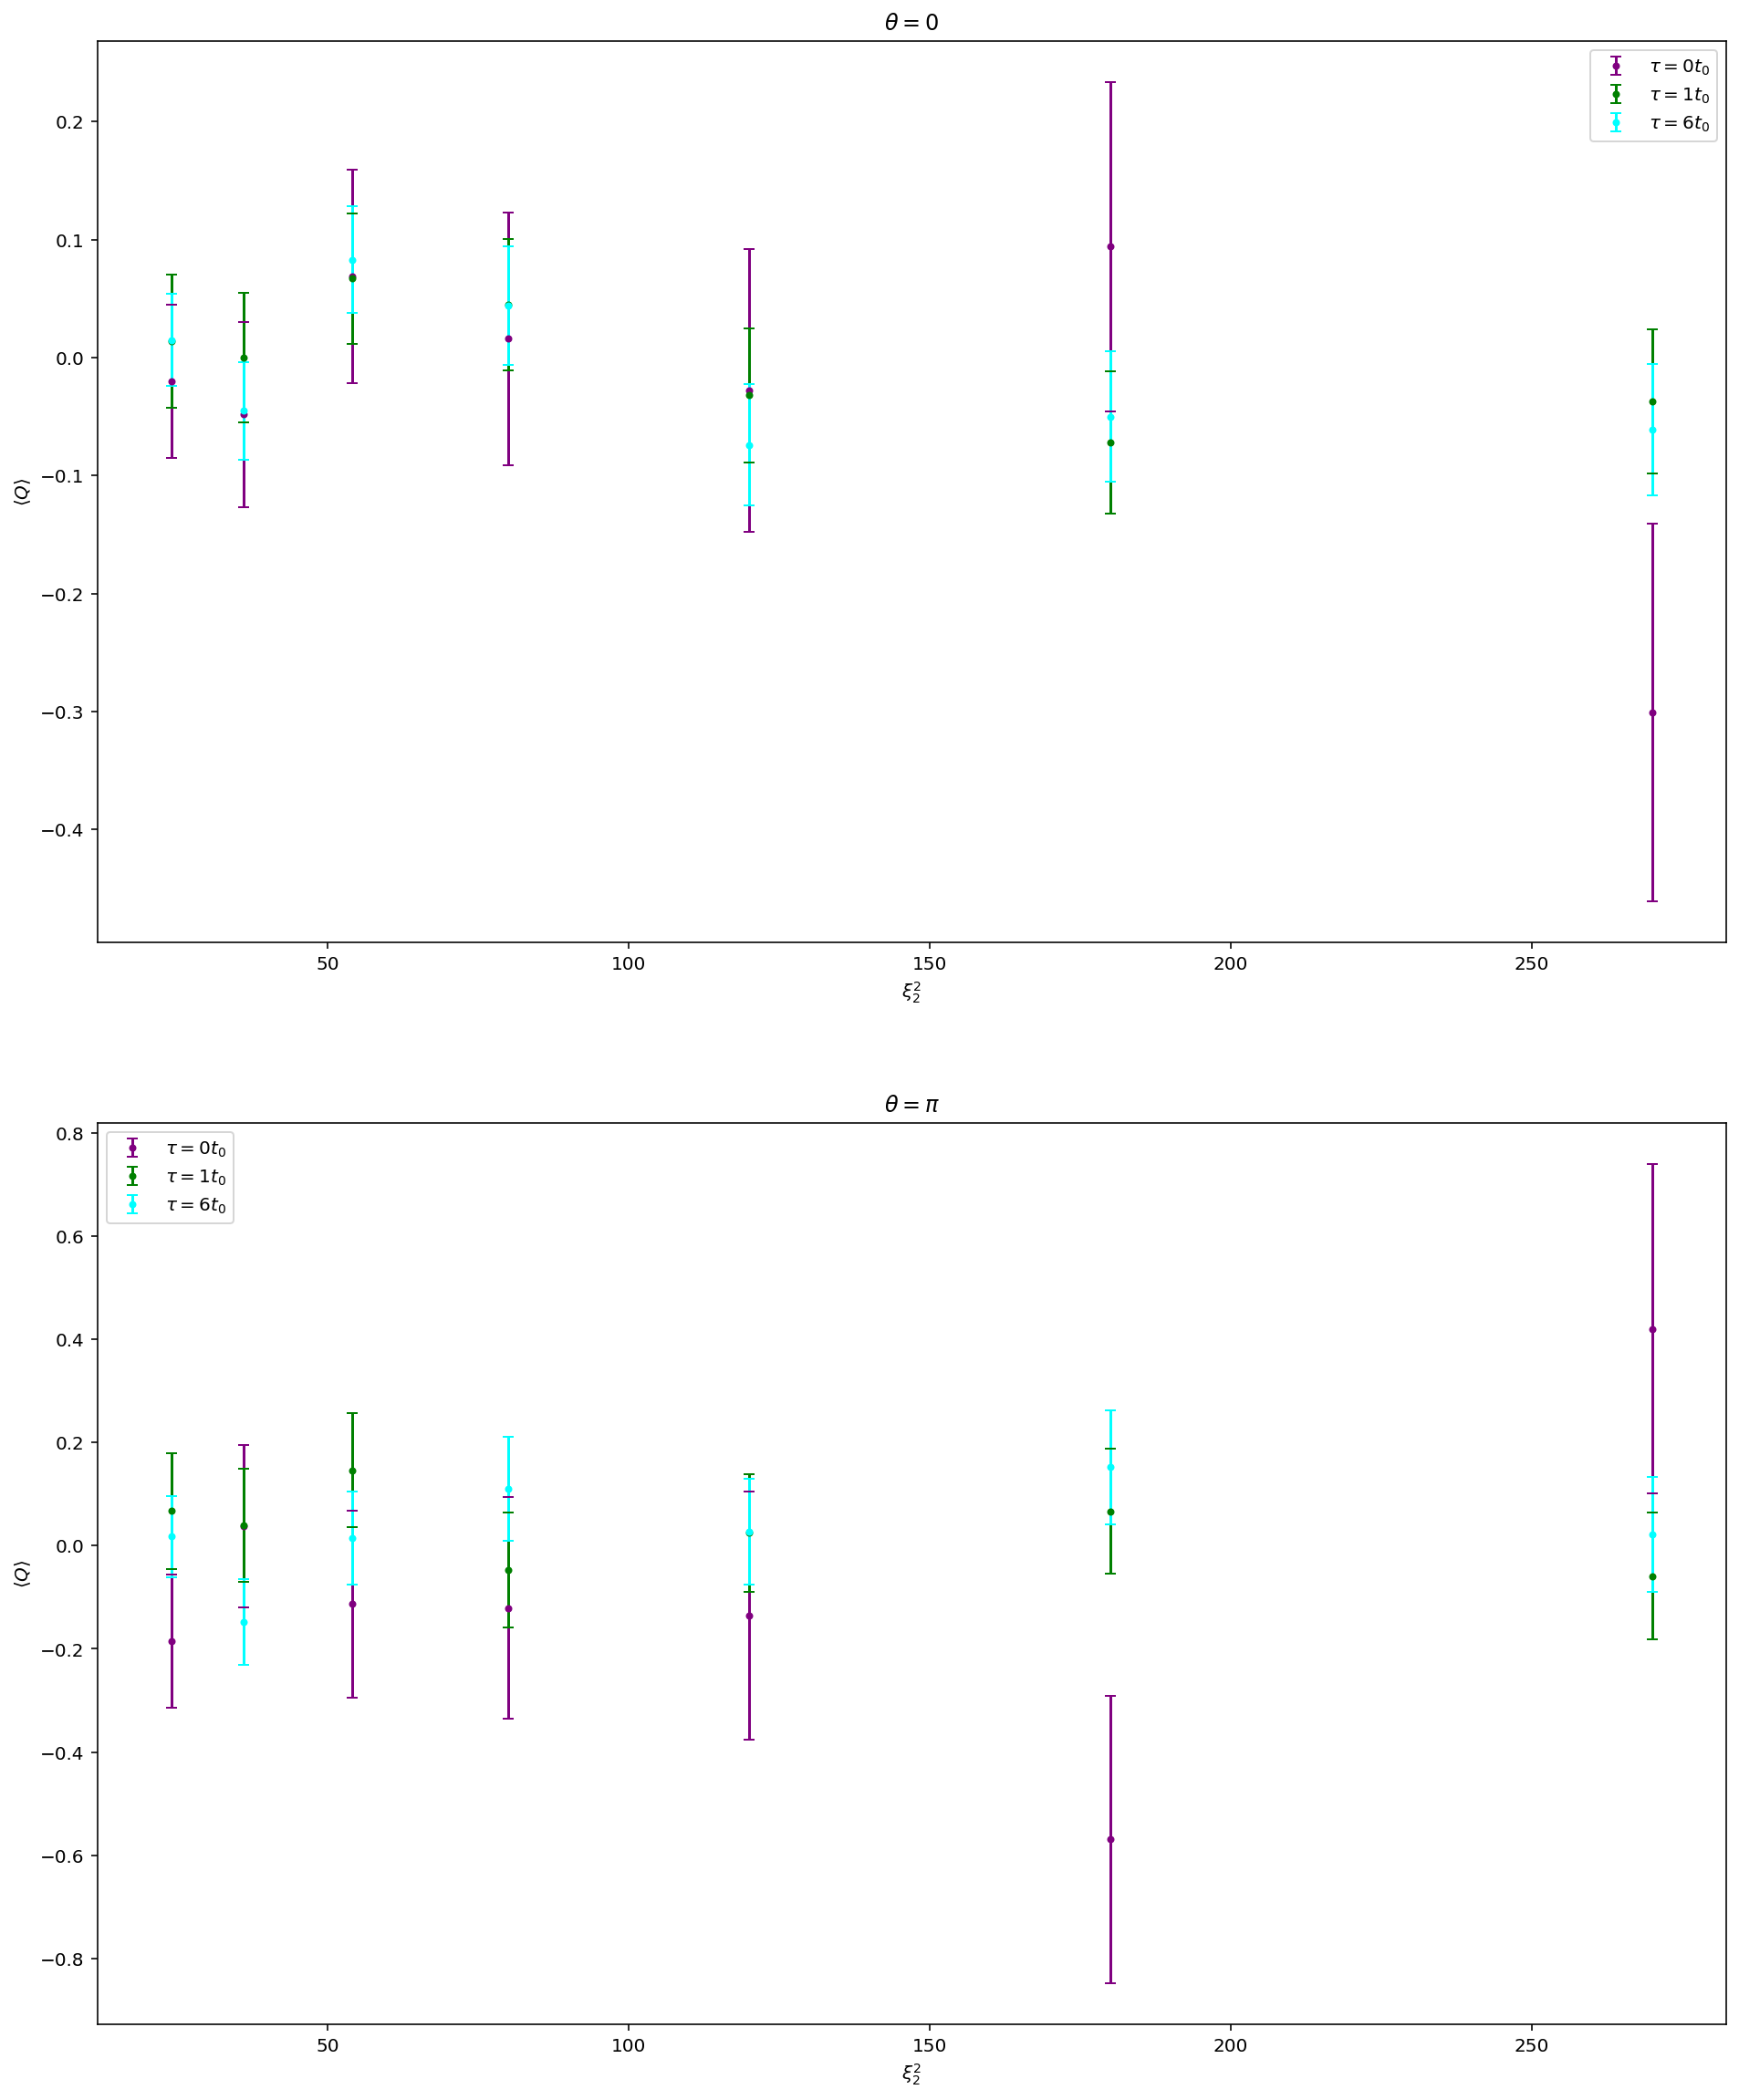

In [110]:
data = get_data()

fig,axes = plt.subplots(2,1,figsize=(16,20))

O = global_observables['Q']

plot_taus = [0,1,6]
#plot_taus = [0,1,2,4,6,8,10]
plot_colors = ['purple', 'green', 'cyan', 'orange', 'blue', 'red', 'black']

for i,tau in enumerate(plot_taus):
    print(tau)
    dtriv = []
    dtopo = []

    Ls = []
    for j,p in bietenholz_params.iterrows():
        trial = data[(round(data['tau'],10) == round(tau*p.t0,10)) & (data['L'] == p.L)]
        if trial.size == 0: continue
            
        Ls.append(p.L)
        dtriv.append(O(trial))
        
        dtopo.append( O(trial[trial.Q%2==0]) - O(trial[trial.Q%2==1]) )

    axes[0].errorbar(Ls, [x.mean for x in dtriv], yerr=[x.sdev for x in dtriv], fmt='.', c=plot_colors[i], label=f"$\\tau={tau}t_0$", capsize=3.)
    axes[1].errorbar(Ls, [x.mean for x in dtopo], yerr=[x.sdev for x in dtopo], fmt='.', c=plot_colors[i], label=f"$\\tau={tau}t_0$", capsize=3.)


axes[0].set_title(r"$\theta=0$")
axes[1].set_title(r"$\theta=\pi$")
axes[0].set_yscale(O.scale)
for ax in axes:
    ax.legend()
    ax.set_ylabel(r"$\langle Q \rangle$");
    ax.set_xlabel(r"$\xi_2^2$")

plt.show()

In [ ]:
from scipy.misc import derivative
from scipy.optimize import curve_fit
from functools import partial
thetas = [-0.1, 0.1] #np.linspace(-np.pi,np.pi,200)


data = get_data()

xi2s = bietenholz_params.xi2.to_numpy()
y = np.zeros_like(xi2s)
plt.figure(figsize=(16,10))

for tau in taus[::2]:
    for i,p in bietenholz_params.iterrows():
        chi = derivative(partial(get_iQ,L=p.L,tau=tau*p.t0), 0., dx=0.01)        
        y[i] = chi #/ L**2 * xi2**2
        
    plt.plot(xi2s, y, '*', label=f"$\\tau={tau}t_0$")
    plt.ylabel(r"$\chi_t \xi_2^2$");
    plt.xlabel(r"$\xi_2^2$")
    plt.legend()

[1.96459280e+01 1.45518454e-02 2.32800712e+01]


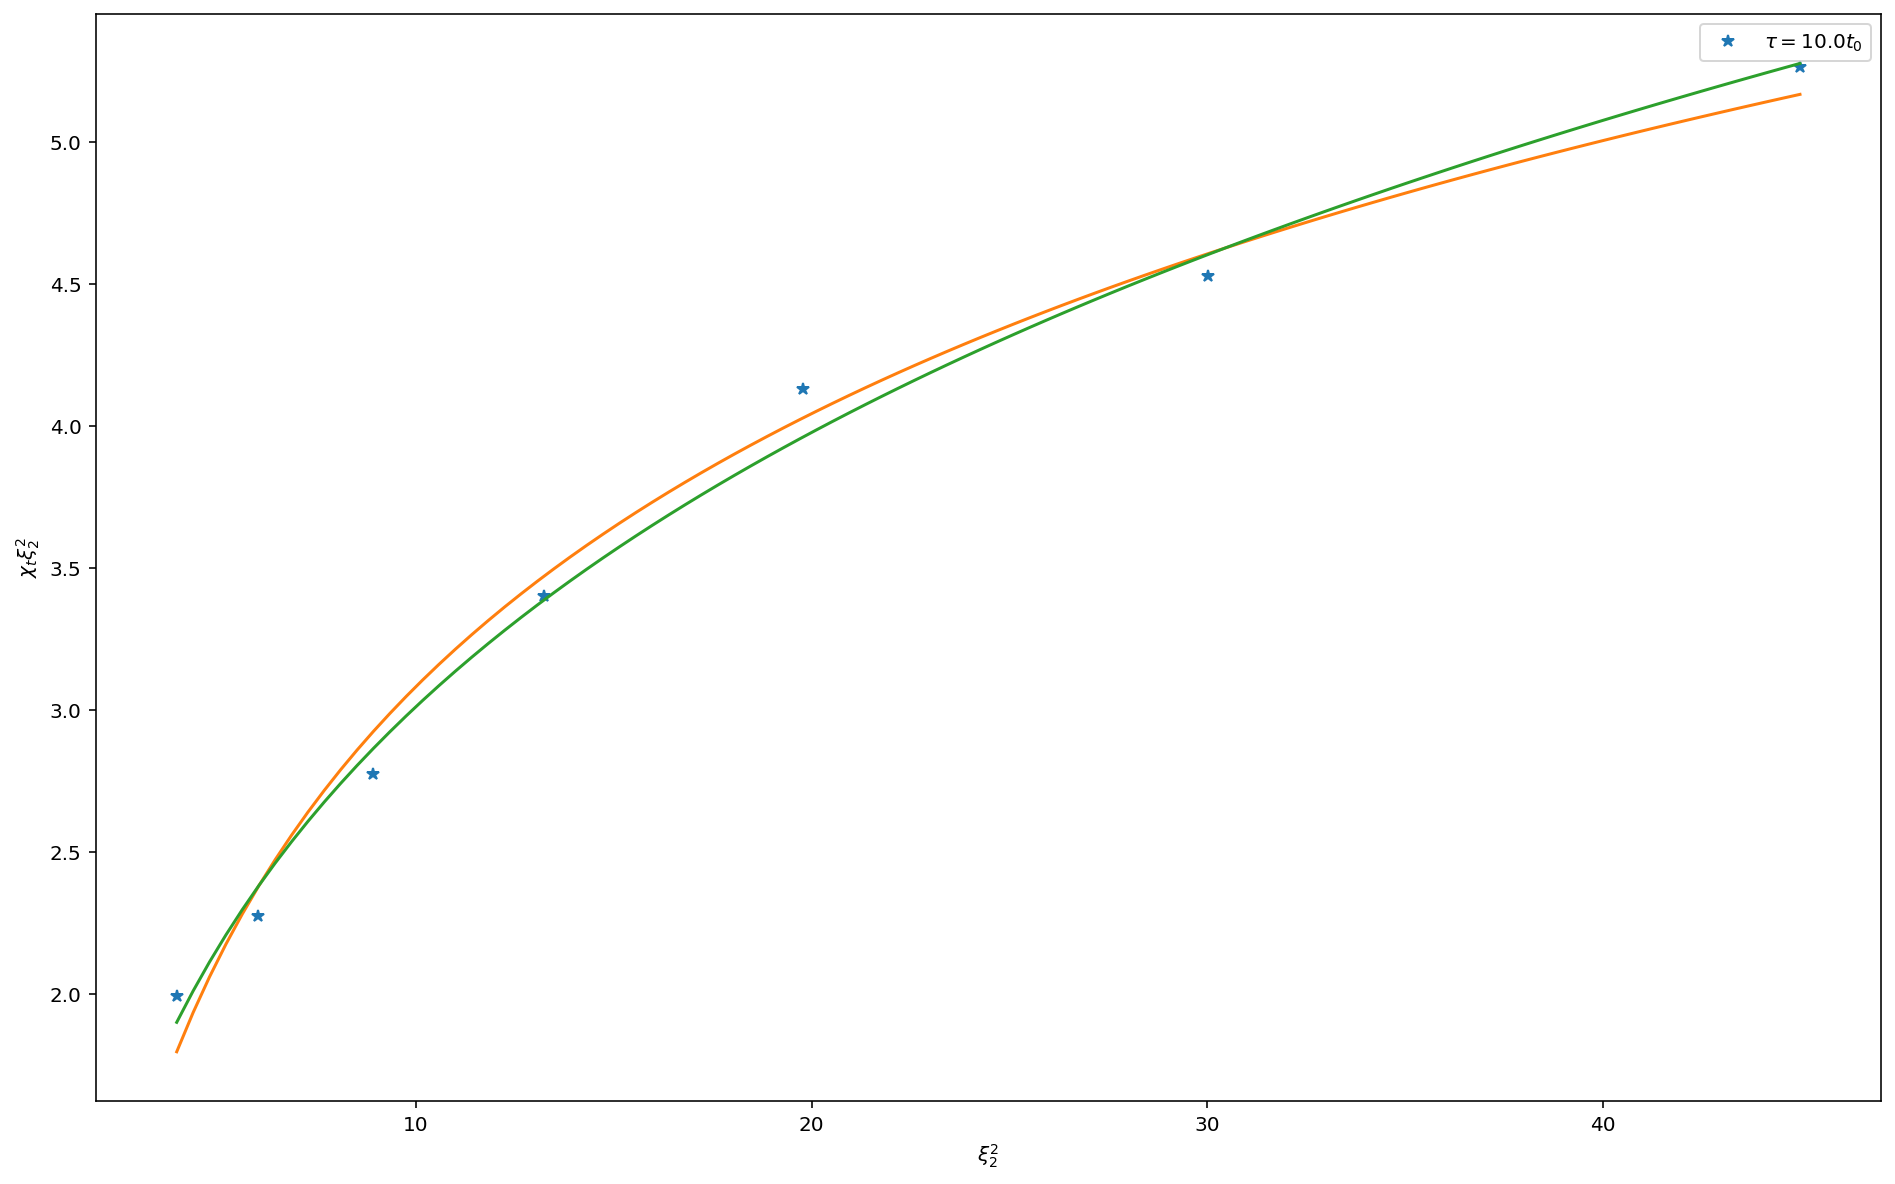

In [47]:
xi2s = bietenholz_params.xi2.to_numpy()
y = np.zeros_like(xi2s)
plt.figure(figsize=(16,10))

tau = 10.
for i,p in bietenholz_params.iterrows():
    chi = derivative(partial(get_iQ,L=p.L,tau=tau*p.t0), 0., dx=0.01)        
    y[i] = chi #/ L**2 * xi2**2

plt.plot(xi2s, y, '*', label=f"$\\tau={tau}t_0$")
plt.ylabel(r"$\chi_t \xi_2^2$");
plt.xlabel(r"$\xi_2^2$")
plt.legend()
    
def fitlog(x,A,B,C):
    return A*np.log(B*x)+C

def fitpow(x,A,B,C):
    return A*(x**B)+C


fit_x = np.linspace(np.amin(xi2s), np.amax(xi2s), 100)

popt, pcov = curve_fit(fitlog, xi2s, y, p0=(1, 1, 0))
plt.plot(fit_x, fitlog(fit_x, *popt), label="Eq. 4.1 fit (log)")

print(np.diagonal(pcov))

popt, pcov = curve_fit(fitpow, xi2s, y, p0=(1, 1, 0))
plt.plot(fit_x, fitpow(fit_x, *popt), label="Eq. 4.2 fit (power)")
    
print(np.diagonal(pcov))
    